# Othello reinforcement learning

## Installation and module imports

In [28]:
import os
#assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [29]:
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

In [ ]:
!pip install torch===1.7.0 torchvision===0.8.1 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install numpy jupyterlab matplotlib pandas scikit-learn

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#import torch_xla
#import torch_xla.core.xla_model as xm

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from IPython.display import display # to display images

import math
import random
import numpy as np

from enum import Enum

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Creates a random tensor on xla:1 (a Cloud TPU core)
#device = xm.xla_device()
if torch.cuda.device_count():
    print(torch.cuda.get_device_name(0))
else:
    print("No GPU")

No GPU


## Othello implementation

In [32]:
class Signal(Enum):
    BEGIN_GAME = 1,
    VALID_MOVE = 2,
    ILLEGAL_MOVE = 3,
    GAME_OVER = 4


class Board():
    """
    Othello is a 8x8 grid
    [Black ; empty; White] -> [-1; 0; 1]
    """

    def __init__(self):
        self.player = 1 # White first
        self.state = np.zeros((8, 8), dtype=int) # Grid representation
        self.memory = [] # To undo moves
        self.reset() # Clear & populates central cells

    def reset(self):
        self.state = np.zeros((8, 8), dtype=int)
        self.set_cell(3, 3, 1)
        self.set_cell(4, 4, 1)
        self.set_cell(3, 4, -1)
        self.set_cell(4, 3, -1)
        self.player = 1 # White first
        begin_signal = Signal.BEGIN_GAME
        self.memory = [(np.copy(self.state), begin_signal)]
        return self.get_observation(), begin_signal
    
    def get_cell(self, c, l):
        return self.state[c, l]

    def set_cell(self, c, l, val):
        self.state[c, l] = val
    
    def flip_cell(self, c, l):
        self.state[c, l] = -self.state[c, l]

    def step(self, action):
        # Save state in memory
        self.memory.append((np.copy(self.state), self.player))
        result_signal = self.do(action)
        return self.get_observation(), result_signal
    
    def do(self, action) -> Signal:
        # If player skip turn when he could move
        if action == None:
            if self.can_player_move():
                return Signal.ILLEGAL_MOVE
            else:
                self.changes_player()
                return Signal.VALID_MOVE
        # Player didn't skip turn, get coordinates
        (c, l) = action
        # Check if player didn't move on an occupied cell
        if self.get_cell(c, l) != 0:
            return Signal.ILLEGAL_MOVE
        # Get nb of cells flipped by the action
        flips = []
        for (di, dj) in [(0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1)]:
            flips += self.get_flips_in_dir(c, l, di, dj)
        # If flips is empty then the move is useless and qualified illegal
        if len(flips) == 0:
            return Signal.ILLEGAL_MOVE
        # If flips is not empty, apply and flip tokens 
        self.set_cell(c, l, self.player)
        for (c, l) in flips:
            self.flip_cell(c, l)
        # Il none of the players can move, game is over
        self.changes_player()
        if not self.can_player_move():
            self.changes_player()
            if not self.can_player_move():
                return Signal.GAME_OVER
        # If everything is good then send valid signal
        return Signal.VALID_MOVE
    
    def undo(self):
        if len(self.memory) != 0:
            (state, player) = self.memory.pop()
            self.player = player
            self.state = state

    def changes_player(self):
        # Changes the token color (Black 1 or White -1)
        self.player = -self.player
    
    def can_player_move(self):
        actions = self.get_possible_actions()
        return len(actions) != 0

    def get_possible_actions(self):
        # For each empty cell, compute if any move can flip tokens
        # If move is valid, add coordinates (c, l) in [actions]
        actions = []
        for c in range(8):
            for l in range(8):
                if self.get_cell(c, l) == 0:
                    for (di, dj) in [(0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1), (-1, 0), (-1, 1)]:
                        _flips = self.get_flips_in_dir(c, l, di, dj)
                        if len(_flips) != 0:
                            actions.append((c, l))
        return actions
    
    def sample(self):
        # Randomly choose in possible actions
        actions = self.get_possible_actions()
        if len(actions) == 0:
            return None
        # return actions[0]
        return random.choice(actions)

    def get_flips_in_dir(self, c, l, di, dj):
        # Move a step forward in the direction
        c += di
        l += dj
        # Compute the list of (c, l) to flip
        flips = []
        while c >= 0 and c < 8 and l >= 0 and l < 8:
            cell_id = self.get_cell(c, l)
            if cell_id == -self.player:
                flips.append((c, l)) # Possible flip
            elif cell_id == self.player:
                return flips
            else:
                return []
            # Move forward
            c += di
            l += dj
        return []

    def get_winner(self):
        white = self.get_white_score()
        black = self.get_black_score()
        if white > black:
            return 1
        elif white < black:
            return -1
        else:
            return 0
    
    def get_observation(self):
        observation = np.zeros((2, 8, 8), dtype=int)
        observation[0] = (self.state == 1)
        observation[1] = (self.state == -1)
        return observation
    
    def render(self, state=None):
        if not state:
            state = self.state
        print("---" * 8)
        for l in range(8):
            line = ""
            for c in range(8):
                cell_id = state[c, l]
                if cell_id == 1:
                    line += "X\t"
                elif cell_id == -1:
                    line += "O\t"
                else:
                    line += f".\t"
                    # line += f"{c+8*l}\t"
            print(line)
        print("---" * 8)

    def get_white_score(self):
        white = (self.state == 1).sum()
        return white

    def get_black_score(self):
        black = (self.state == -1).sum()
        return black        

## Helpers

In [33]:
def encode_action(a):
    if a == 64:
        return None
    else:
        i = a % 8
        j = a // 8
        return (i, j)

In [34]:
def game_over_from_signal(signal: Signal, board: Board):
    game_over = signal in [Signal.GAME_OVER, Signal.ILLEGAL_MOVE]
    return game_over

In [35]:
def render_q(q: list, s = 1):
    dimension = (128, 128)
    max_negative = np.min([np.min(q), 0])
    max_positive = np.max([np.max(q), 0])
    image = Image.new('RGBA', dimension, (255,255,225,255))
    draw = ImageDraw.Draw(image)
    draw.rectangle([(0, 0), (128, 128)], fill=(255,255,255,255))
    y = 0
    i = 0
    for l in range(8):
        x = 0
        for c in range(8):
            xy = [(x + 1, y + 1), (x + 14, y + 14)]
            r = q[i]
            if r > 0:
                a = min(255, max(0, int(r * s * 255)))
                # a = int(r / max_positive * 255)
                color = (0, 0, 255, a)
            elif r < 0:
                a = min(255, max(0, int(-r * s * 255)))
                # a = int(r / max_negative * 255)
                color = (255, 0, 0, a)
            draw.rectangle(xy, fill=color)
            x += 16
            i += 1
        y += 16
    display(image)

def render_qs(qs: list, s = 1):
    n_columns = max(1, min(len(qs), 8))
    n_rows = max(1, len(qs) // n_columns)

    cell_size = 16
    n_cells = 8
    padding  = cell_size
    unit_size = 128

    total_height = (unit_size + padding) * n_rows - padding
    total_width = (unit_size + padding) * n_columns - padding
    image = Image.new('RGBA', (total_width, total_height), (255,255,255,0))

    draw = ImageDraw.Draw(image)
    draw.rectangle([(0, 0), (total_width, total_height)], fill=(255,255,255,0))

    y = 0
    k = 0
    for row in range(n_rows):
        x = 0
        for column in range(n_columns):
            yy = y
            i = 0
            for l in range(n_cells):
                xx = x
                for c in range(n_cells):
                    xxyy = [(xx + 1, yy + 1), (xx + cell_size - 2, yy + cell_size - 2)]
                    r = qs[k][i]
                    if r > 0:
                        a = min(255, max(0, int(r * s * 255)))
                        color = (0, 0, 255, a)
                    elif r < 0:
                        a = min(255, max(0, int(-r * s * 255)))
                        color = (255, 0, 0, a)
                    draw.rectangle(xxyy, fill=color)
                    xx += 16
                    i += 1
                yy += 16
            x += unit_size + padding
            k += 1
        y += unit_size + padding
    display(image)

## Model

In [82]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Input (2, 8, 8,) # 2*8*8 = 128
        # Output (65,)
        self.input_layer = nn.Linear(128, 2048)
        self.hidden_layer_1 = nn.Linear(2048, 1024)
        self.hidden_layer_2 = nn.Linear(1024, 512)
        self.hidden_layer_3 = nn.Linear(512, 256)
        self.hidden_layer_4 = nn.Linear(256, 128)
        self.output_layer = nn.Linear(128, 65)

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.tanh(self.input_layer(x))
        x = F.tanh(self.hidden_layer_1(x))
        x = F.tanh(self.hidden_layer_2(x))
        x = F.tanh(self.hidden_layer_3(x))
        x = F.tanh(self.hidden_layer_4(x))
        output = F.tanh(self.output_layer(x))
        return output

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## Training

Before learning:


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


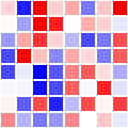

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


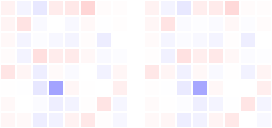

-0.00533892803807528
After 16 steps: [(3, 5), (2, 3), (3, 5)]
Epsilons [88.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


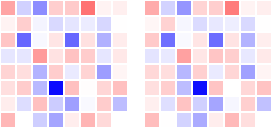

-0.0018556041356462699
After 32 steps: [(3, 5), (2, 5), (3, 5)]
Epsilons [78.0, 79.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


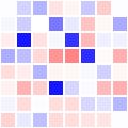

0.03968470154168944
After 48 steps: [(1, 2)]
Epsilons [69.0, 79.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


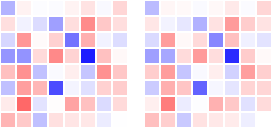

-0.03294232327920886
After 64 steps: [(5, 3), (5, 4), (5, 3)]
Epsilons [60.0, 79.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


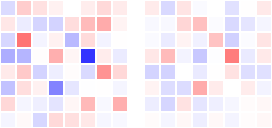

-0.007483118108043877
After 80 steps: [(5, 3), (3, 2), (3, 3)]
Epsilons [53.0, 79.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


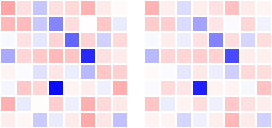

-0.025260117248846935
After 96 steps: [(3, 5), (2, 5), (3, 5)]
Epsilons [48.0, 51.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


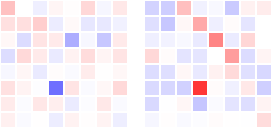

-0.010467907086086388
After 112 steps: [(3, 5), (4, 5), (3, 6)]
Epsilons [42.0, 51.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


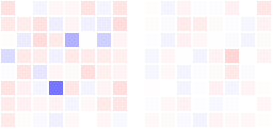

-0.01760553759880937
After 128 steps: [(3, 5), (2, 5), (3, 3)]
Epsilons [37.0, 51.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


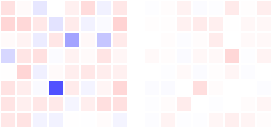

-0.022239175213214297
After 144 steps: [(3, 5), (2, 3), (1, 5)]
Epsilons [33.0, 33.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


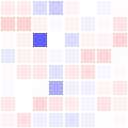

-0.009425576138668335
After 160 steps: [(2, 2)]
Epsilons [31.0, 33.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


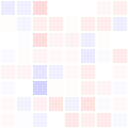

-0.0138863805663557
After 176 steps: [(2, 5)]
Epsilons [26.0, 26.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


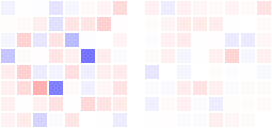

-0.011918674889378823
After 192 steps: [(5, 3), (5, 4), (0, 4)]
Epsilons [23.0, 26.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


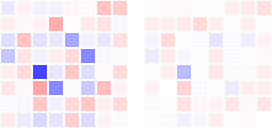

-0.004877198888705327
After 208 steps: [(2, 4), (2, 3), (2, 4)]
Epsilons [20.0, 22.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


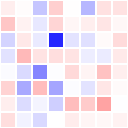

-0.003574511675665585
After 224 steps: [(3, 2)]
Epsilons [18.0, 18.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


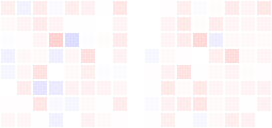

-0.020220634982419702
After 240 steps: [(4, 2), (3, 2), (4, 2)]
Epsilons [16.0, 18.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


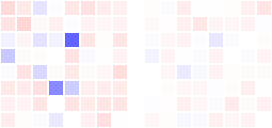

-0.019426130167602633
After 256 steps: [(4, 2), (5, 2), (4, 2)]
Epsilons [14.0, 14.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


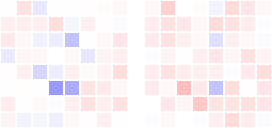

-0.0063196341363856426
After 272 steps: [(3, 5), (2, 3), (4, 5)]
Epsilons [13.0, 14.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


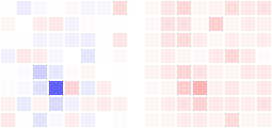

0.01224251514336524
After 288 steps: [(3, 5), (4, 5), (7, 3)]
Epsilons [11.0, 14.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


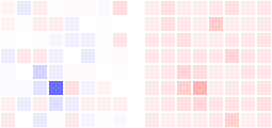

0.006921714714889486
After 304 steps: [(3, 5), (4, 5), (1, 7)]
Epsilons [10.0, 14.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


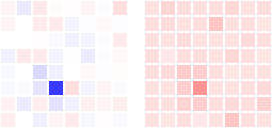

0.007817261506212302
After 320 steps: [(3, 5), (4, 5), (1, 3)]
Epsilons [9.0, 14.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


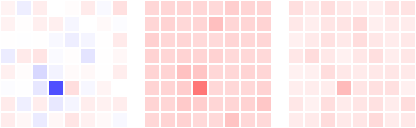

-0.0018661858048290014
After 336 steps: [(3, 5), (2, 3), (4, 2), (3, 6), (3, 3)]
Epsilons [8.0, 14.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


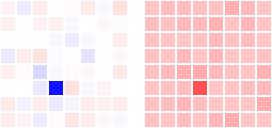

-0.0008716276811005977
After 352 steps: [(3, 5), (4, 5), (6, 7)]
Epsilons [7.0, 14.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


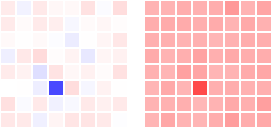

-0.025556827139539214
After 368 steps: [(3, 5), (4, 5), (3, 6)]
Epsilons [6.0, 14.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


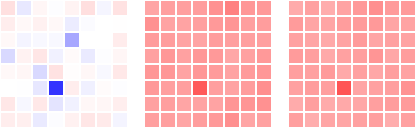

0.005635531139201843
After 384 steps: [(3, 5), (4, 5), (5, 3), (2, 5), (2, 0)]
Epsilons [5.0, 6.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


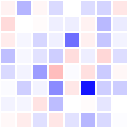

0.08487614468635561
After 400 steps: [(5, 5)]
Epsilons [5.0, 5.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


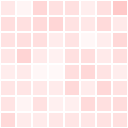

-0.10653795299048607
After 416 steps: [(3, 4)]
Epsilons [5.0, 5.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


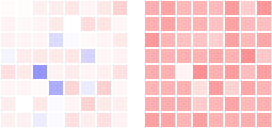

-0.042028643022506286
After 432 steps: [(2, 4), (2, 5), (2, 4)]
Epsilons [4.0, 5.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


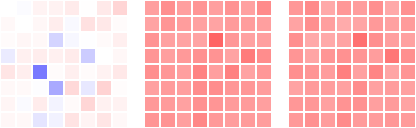

-0.018137826247570606
After 448 steps: [(2, 4), (2, 5), (5, 3), (1, 4), (3, 1)]
Epsilons [3.0, 5.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


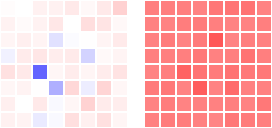

-0.03452045801274765
After 464 steps: [(2, 4), (4, 5), (4, 7)]
Epsilons [3.0, 5.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


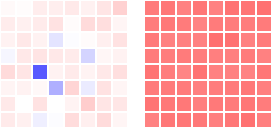

-0.047676584801564996
After 480 steps: [(2, 4), (2, 5), (2, 4)]
Epsilons [3.0, 5.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


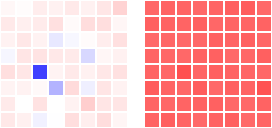

-0.04720268630458472
After 496 steps: [(2, 4), (2, 3), (3, 7)]
Epsilons [3.0, 5.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


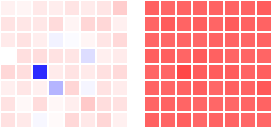

-0.06987655961241286
After 512 steps: [(2, 4), (4, 5), (3, 6)]
Epsilons [2.0, 5.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


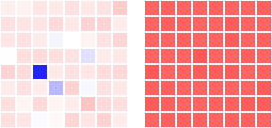

-0.08264946346887603
After 528 steps: [(2, 4), (2, 5), (3, 2)]
Epsilons [2.0, 5.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


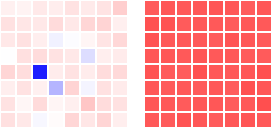

-0.07253780346363783
After 544 steps: [(2, 4), (2, 5), (2, 4)]
Epsilons [2.0, 5.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


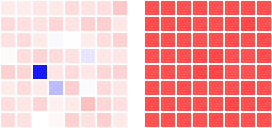

-0.09612458851188421
After 560 steps: [(2, 4), (2, 5), (6, 4)]
Epsilons [2.0, 5.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0]


In [ ]:
# Game board
board = Board()

# Neural net
model = Model()
model.to(device)
learning_rate = 1e-4
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# History and batch
batch = []
batch_size = 16

# Sample Q before learning
print("Before learning:")
s, sig = board.reset()
Q = model(torch.tensor(s, dtype=torch.float).unsqueeze(0).to(device))
render_q(Q.to("cpu").tolist()[0], s=10)

def add_to_batch(s, iQmax, r, n_s, done):
    batch.append((s, iQmax, r, n_s, done))
    if len(batch) > batch_size:
        batch.pop(0)

def train_on_batch():
    inputs = torch.zeros(batch_size, 2, 8, 8).to(device) # All states
    target_Qs = torch.zeros(batch_size, 65).to(device) # All corrected Qs with rewards
    # Populate Qs and target_Qs tensors
    for i, (s, iQmax, r, n_s, done) in enumerate(batch):
        Qs = model(torch.tensor(s, dtype=torch.float).unsqueeze(0).to(device))
        target_Qs[i] = Qs
        if done:
            target_Qs[i, iQmax] = r
        else:
            Qn_s = model(torch.tensor(n_s, dtype=torch.float).unsqueeze(0).to(device))
            target_Qs[i, iQmax] = r + 0.1 * (0.9 * torch.max(Qn_s) - torch.max(Qs))
        target_Qs = torch.clip(target_Qs, -3, 3) # Clamp to avoid grad boom
    model.train() # Switch on train mode
    Qs = model(torch.tensor(inputs, dtype=torch.float).to(device)) # Q
    loss = criterion(target_Qs.to(device), Qs) # Compute difference between Q and target Q
    optimizer.zero_grad() # Reset gradients to perform backprop
    loss.backward() # Backprop
    optimizer.step() # Apply changes

def summary():
    Qs = []
    done = False
    s, sig = board.reset()
    actions = []
    while not done:
        Q = model(torch.tensor(s, dtype=torch.float).unsqueeze(0).to(device)).to("cpu")
        Qs.append(Q.tolist()[0])
        iQmax = torch.argmax(Q).item()
        white_a = encode_action(iQmax)
        actions.append(white_a)
        s, sig = board.step(white_a)
        done = sig in [Signal.GAME_OVER, Signal.ILLEGAL_MOVE]
        if done:
            break
        black_a = board.sample()
        actions.append(black_a)
        s, sig = board.step(black_a)
        done = sig in [Signal.GAME_OVER, Signal.ILLEGAL_MOVE]
    render_qs(Qs, s = 1)
    print(np.mean(Qs[0]))
    return actions

n_epochs = 4096
# Epsilon exp decreasing - one eps per #move played up to 32 moves
epsilon_start = 0.99
epsilon_end = 0.01
epsilon_decay = 128
epsilons = [epsilon_start] * 32

for i in range(n_epochs):
    # Reset board
    done = False
    length = 0
    s, sig = board.reset()
    actions = [] # keep track of played actions to reward worse when replay

    while not done:
        # Produce action
        a = None
        if random.random() < epsilons[length]:
            iQmax = random.randint(0, 64)
            a = encode_action(iQmax)
        else:
            Q = model(torch.tensor(s, dtype=torch.float).unsqueeze(0).to(device))
            iQmax = torch.argmax(Q).item()
            a = encode_action(iQmax)

        # Play the action on the board
        n_s, sig = board.step(a)
        
        # Get reward and game over
        done = sig in [Signal.GAME_OVER, Signal.ILLEGAL_MOVE]
        r = 0
        if sig is Signal.ILLEGAL_MOVE:
            r = -0.1
        elif sig is Signal.VALID_MOVE:
            r = 1 + length
        actions.append(a)
        
        if not done:
            epsilons[length] = epsilon_end + (epsilon_start - epsilon_end) * math.exp(-1. * i / epsilon_decay)
            a = board.sample()
            actions.append(a)
            n_s, sig = board.step(a)
            done = sig in [Signal.GAME_OVER, Signal.ILLEGAL_MOVE]

        # Learn
        add_to_batch(s, iQmax, r, n_s, done)
        train_on_batch()

        length += 1

    # Sample Q after learning
    if i % 16 == 15:
        print(f"After {i + 1} steps: {summary()}")
        print(f"Epsilons {(np.floor(100 * np.array(epsilons))).tolist()}")
        
